# Segmenting and Clustering Neighborhoods in the city of Houston

## Table of Contents
1. [Introduction](#Introduction)
2. [Data](#Data)
3. [Methodology](#Methodology)
4. [Analysis](#Analysis)
5. [Results](#Results)
6. [Conclusion](#Conclusion)
7. [Discussion](#Discussion)

# <a id = 'Introduction'> 1. Introduction </a>
Houston is located in Southeast Texas near Gulf of Mexico. It is one of the most populous cities in US. Houston is a very diversified and growing city. Its main industries include aerospace and aviation, manufacturing, energy, and life sciences and biotechnology.  

Our client is interested in opening a Chinese restaurant in the Houston area. There are more than 80 neighborhoods in Houston. Each one has its own characteristics. Chinese restaurant may be underrepresented in some neighborhood and they desire more Chinese restaurants while some other neighborhoods have little desire or already have enough Chinese restaurants. This study is to find the best neighborhood for the new restaurant to increase the chance of success. In this study, we’ll consider Chinese food is one branch of Asian food. We’ll check Asian population in the neighborhood as an indicator for demand, number of existing Chinese restaurant to represent competition, and median household income in the neighborhood as buying power. 


# <a id = 'Data'> 2. Data </a>
3 sets of data are acquired for this study. 
1. Obtain the neighborhood information from [houstontx.gov](#https://www.houstontx.gov/planning/Demographics/super_neighborhoods_2.html). 
The website has links to PDF files, one for each neighborhood, which contains information about the neighborhoods. The PDF file has both 2000 and 2017 data, we'll only use the 2017 data and extract 'Total Population', 'Population density', 'Ethnicity' and 'Median Household Income'. For Ethnicity, only keep the Asians part.
2. Obtain latitude/longitude for each neighborhood
Tried using geocoder to get the latitude/longitude information and not working. Most likely it requests a google account. Instead, I extracted the latitude/longitdue manually using google earth and cross checking with ArcGIS, the information was saved as an excel file
3. Using the latitude/longtitude to get venue information from foursquare

Libraries needed for this study

In [1]:
#import libraries needed for this work
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

import re

from geopy.geocoders import Nominatim
import geocoder

import folium # map rendering library
import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Preprocessing, K-means
from sklearn import preprocessing
from sklearn.cluster import KMeans

In [2]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.2.2


## 2.1: Obtain and clean up neighborhood information

### 2.1.1: Get a list of PDF files from the above website

In [3]:
import camelot
from bs4 import BeautifulSoup

In [4]:
url = 'https://www.houstontx.gov/planning/Demographics/super_neighborhoods_2.html'

In [5]:
req =requests.get(url)
soup=BeautifulSoup(req.content, 'lxml')
print(soup.prettify())

<!DOCTYPE HTML>
<!--[if lt IE 7]> <html class="ie6 oldie"> <![endif]-->
<!--[if IE 7]>    <html class="ie7 oldie"> <![endif]-->
<!--[if IE 8]>    <html class="ie8 oldie"> <![endif]-->
<!--[if gt IE 8]><!-->
<html lang="en">
 <!-- InstanceBegin template="/Templates/layout.dwt" codeOutsideHTMLIsLocked="false" -->
 <head>
  <!-- InstanceBeginEditable name="doctitle" -->
  <title>
   Demographic Data
  </title>
  <script language="JavaScript" src="../SpryAssets/SpryAccordion.js" type="text/javascript">
  </script>
  <link href="../SpryAssets/SpryAccordion.css" rel="stylesheet" type="text/css"/>
  <!-- InstanceEndEditable -->
  <meta content="4fd5623d4815ebed-85eb79efd904ef3b-g1d18c5a41208be6d-17" name="google-translate-customization"/>
  <meta charset="utf-8"/>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <!--[if lte IE 8]><script src="https://houstontx.gov/_siteAssets/js/ie/html5shiv.js"></script><![endif]-->
  <link href="style.css" rel="stylesheet"/>
  <link

In [6]:
dict_pdf={}

# remove the extra information between () for neighborhood name 
# and strip out space at the beginning and end of neighborhood name
# ex. Central Northwest has name of "Central Northwest (formerly Near Northwest)"
for a in soup.find_all('a', href=True):
    if '.pdf' in str(a) and '2017' in str(a):
        neighborhood = a.text
        if '(' in a.text:
            regex = re.compile("(.*?)\((.*?)\)")
            neighborhood = re.findall(regex, a.text)[0][0]
        neighborhood = neighborhood.strip().replace('Super Neighborhood#: ', '')
        dict_pdf[neighborhood] = 'https://www.houstontx.gov/planning/Demographics/'+a['href'].replace(' ','%20')

In [7]:
len(dict_pdf)

88

In [8]:
dict_pdf

{'Acres Home': 'https://www.houstontx.gov/planning/Demographics/docs_pdfs/SN/2017/Acres_Home_Final.pdf',
 'Addicks Park Ten': 'https://www.houstontx.gov/planning/Demographics/docs_pdfs/SN/2017/Addicks%20Park%20Ten_Final.pdf',
 'Afton Oaks / River Oaks': 'https://www.houstontx.gov/planning/Demographics/docs_pdfs/SN/2017/Afton%20Oaks%20River%20Oaks%20Area_Updated.pdf',
 'Alief': 'https://www.houstontx.gov/planning/Demographics/docs_pdfs/SN/2017/Alief_Final_Update.pdf',
 'Astrodome Area': 'https://www.houstontx.gov/planning/Demographics/docs_pdfs/SN/2017/Astrodome%20Area_Final.pdf',
 'Braeburn': 'https://www.houstontx.gov/planning/Demographics/docs_pdfs/SN/2017/Braeburn_Final.pdf',
 'Braeswood': 'https://www.houstontx.gov/planning/Demographics/docs_pdfs/SN/2017/Braeswood_Final.pdf',
 'Brays Oaks': 'https://www.houstontx.gov/planning/Demographics/docs_pdfs/SN/2017/Brays%20Oaks_Final.pdf',
 'Briar Forest': 'https://www.houstontx.gov/planning/Demographics/docs_pdfs/SN/2017/Briar%20Forest_Fin

### 2.1.2: Extract information for the PDF files

Define a function to extract the following information fro the PDF files
- Population, Person per sq. miles, Ethnicity, Median household Income
- Ethnicity includes 'Non Hispanic Whites', 'Non Hispanic Blacks', 'Hispanics', 'Non Hispanic Asians', 'Non Hispanic Others'


In [9]:
#Ethn = ['Whites', 'Blacks', 'Hispanics', 'Asians', 'Others']
headers = ['Neighborhood','Population','Pop_density', 'p_w','p_b', 'p_h', 'p_a', 'p_o', 'Income'] #headers for output dataframe

def extract_pdf(neighborhood, file):
#    df_out = pd.DataFrame(columns=headers) #Defines output

    my_tables1 = camelot.read_pdf(file, flavor='stream', table_regions=['40,440,360,240'], split_text=True)
    my_tables2 = camelot.read_pdf(file, flavor='stream', table_regions=['40,240,360,85'], split_text=True)
    a = pd.concat([my_tables1[0].df,my_tables2[0].df])

    pop = int(a[a.iloc[:,0]=='Total population'].iloc[0,2].replace(',',''))
    ppm = int(a[a.iloc[:,0]=='Persons per sq. mile'].iloc[0,2].replace(',',''))
    p_w = int(a[a.iloc[:,0]=='Non Hispanic Whites'].iloc[0,2].replace('%',''))
    p_b = int(a[a.iloc[:,0]=='Non Hispanic Blacks'].iloc[0,2].replace('%',''))
    p_h = int(a[a.iloc[:,0]=='Hispanics'].iloc[0,2].replace('%',''))
    p_a = int(a[a.iloc[:,0]=='Non Hispanic Asians'].iloc[0,2].replace('%',''))
    p_o = int(a[a.iloc[:,0]=='Non Hispanic Others'].iloc[0,2].replace('%',''))
    incom = a[a.iloc[:,0].str.cat(a.iloc[:,1], sep='').str.contains('Median\sHousehold\sIncome')].iloc[0,2].replace('$','').replace(',','')
#    print ('{}, {}, {}, {},{}, {}, {}, {}'.format(pop, ppm, p_w, p_b, p_h, p_a, p_o, incom))
    df_out= pd.DataFrame([[neighborhood, pop, ppm, p_w, p_b, p_h, p_a, p_o, incom]], columns = headers)
    return df_out
    
    

In [35]:
df_neighborhood = pd.DataFrame(columns=headers)
for key, val in dict_pdf.items():
    a = extract_pdf(key, val)
    print (key)
    df_neighborhood = df_neighborhood.append(a, ignore_index=True)

Acres Home
Addicks Park Ten
Afton Oaks / River Oaks
Alief
Astrodome Area
Braeburn
Braeswood
Brays Oaks
Briar Forest
Carverdale
Central Northwest
Central Southwest
Clear Lake
Clinton Park / Tri-Community
Denver Harbor / Port Houston
Downtown
East Houston
East Little York / Homestead
Eastex - Jensen
Edgebrook
El Dorado / Oates Prairie
Eldridge / West Oaks
Fairbanks / Northwest Crossing
Fondren Gardens
Fort Bend / Houston
Fourth Ward
Golfcrest / Bellfort / Reveille
Greater Eastwood
Greater Fifth Ward
Greater Greenspoint
Greater Heights
Greater Hobby
Greater Inwood
Greater OST / South Union
Greater Third Ward
Greater Uptown
Greenway / Upper Kirby
Gulfgate Riverview / Pine Valley
Gulfton
Harrisburg / Manchester
Hidden Valley
Hunterwood
IAH Airport
Independence Heights
Kashmere Gardens
Kingwood
Lake Houston
Langwood
Lawndale / Wayside
Lazybrook / Timbergrove
Macgregor
Magnolia Park
Meadowbrook / Allendale
Medical Center
Memorial
Meyerland
Mid-West
Midtown
Minnetex
Museum Park
Neartown / Mont

In [36]:
# reformat the neighborhood names
df_neighborhood = df_neighborhood.replace({'Neighborhood': ' Area$'}, {'Neighborhood': ''}, regex=True)
df_neighborhood['Neighborhood'] = df_neighborhood['Neighborhood'].str.title()

In [37]:
df_neighborhood

,Neighborhood,Population,Pop_density,p_w,p_b,p_h,p_a,p_o,Income
0,Acres Home,25846,2885,5,67,26,1,1,41358
1,Addicks Park Ten,20694,883,40,19,28,12,1,82869
2,Afton Oaks / River Oaks,14875,4119,75,2,12,9,2,152092
3,Alief,119598,8106,7,24,49,19,1,42928
4,Astrodome,17944,5646,33,20,9,35,3,51510
5,Braeburn,20227,8304,20,15,60,3,2,37879
6,Braeswood,22599,7240,60,7,13,17,3,97320
7,Brays Oaks,65574,8320,13,42,37,7,1,45474
8,Briar Forest,43775,6508,45,21,25,7,2,77819
9,Carverdale,3673,1219,12,24,50,14,0,56949


### 2.1.3: Cleanup the extracted information, save and some initial QC

Drop information not needed for this study

In [38]:
df_neighborhood.drop(['p_w','p_b','p_h','p_o'],axis=1, inplace=True)

Compute area by the ratio of Population and density, then compute radius assuming circle shape

In [39]:
df_neighborhood.head()

,Neighborhood,Population,Pop_density,p_a,Income
0,Acres Home,25846,2885,1,41358
1,Addicks Park Ten,20694,883,12,82869
2,Afton Oaks / River Oaks,14875,4119,9,152092
3,Alief,119598,8106,19,42928
4,Astrodome,17944,5646,35,51510


In [40]:
df_neighborhood['Area']=df_neighborhood['Population']/df_neighborhood['Pop_density']*1609.34*1609.34
df_neighborhood['Area']=df_neighborhood['Area'].astype(int)
df_neighborhood['Radius'] =  np.sqrt(df_neighborhood['Area']/np.pi).astype(int)

Compute Asia population by multiply population with Asian percentage

In [41]:
df_neighborhood['Pop_a'] =  df_neighborhood['Population'] * df_neighborhood['p_a']/100
df_neighborhood['Pop_a'] = df_neighborhood['Pop_a'].astype(int)

In [42]:
df_neighborhood

,Neighborhood,Population,Pop_density,p_a,Income,Area,Radius,Pop_a
0,Acres Home,25846,2885,1,41358,23202946,2717,258
1,Addicks Park Ten,20694,883,12,82869,60698694,4395,2483
2,Afton Oaks / River Oaks,14875,4119,9,152092,9353212,1725,1338
3,Alief,119598,8106,19,42928,38213157,3487,22723
4,Astrodome,17944,5646,35,51510,8231405,1618,6280
5,Braeburn,20227,8304,3,37879,6308698,1417,606
6,Braeswood,22599,7240,17,97320,8084371,1604,3841
7,Brays Oaks,65574,8320,7,45474,20412864,2549,4590
8,Briar Forest,43775,6508,7,77819,17421045,2354,3064
9,Carverdale,3673,1219,14,56949,7803920,1576,514


In [43]:
df_neighborhood.drop(['Population','p_a','Pop_density','Area'], axis=1, inplace = True)
df_neighborhood.head()

,Neighborhood,Income,Radius,Pop_a
0,Acres Home,41358,2717,258
1,Addicks Park Ten,82869,4395,2483
2,Afton Oaks / River Oaks,152092,1725,1338
3,Alief,42928,3487,22723
4,Astrodome,51510,1618,6280


Save the updated dataframe to a dataset  

In [44]:
df_neighborhood.to_csv('./Data/Capstone_Houston_Neighborhood_Statistics.csv')

Some initial QC on the data

In [45]:
df_neighborhood['Pop_a'] = df_neighborhood['Pop_a'].astype(int)
df_neighborhood['Income'] = df_neighborhood['Income'].astype(int)
df_neighborhood['Radius'] = df_neighborhood['Radius'].astype(int)
df_neighborhood.describe()

,Income,Radius,Pop_a
count,88.000000,88.000000,88.000000
mean,56078.375000,2148.556818,1747.056818
std,27077.607409,1000.069582,3290.801245
min,25003.000000,619.000000,0.000000
25%,34877.500000,1526.250000,38.250000
50%,47226.500000,1863.500000,527.500000
75%,74090.500000,2554.250000,1774.500000
max,152092.000000,5384.000000,22723.000000


## 2.2: Combine with Geographical data

### 2.2.1: Get Latitude and longitude coordinates of each Neighborhood

In [46]:
df_g=pd.read_excel('./Data/Houston_Neighborhood_Lan_Lng.xlsx', header = 0)

In [47]:
df_g.head()

,Neighborhood,Latitude_N,Longitude_W,Latitude,Longitude
0,Acres Home,295215.03,952611.21,29.870842,-95.436447
1,Addicks Park Ten,294851.19,953843.82,29.814219,-95.645506
2,Afton Oaks / River Oaks,294454.18,952624.46,29.748383,-95.440128
3,Alief,294101.64,953534.30,29.683789,-95.592861
4,Astrodome,294103.99,952411.31,29.684442,-95.403142


In [48]:
df_g.drop(['Latitude_N','Longitude_W'], axis = 1, inplace=True)

In [49]:
df_g['Neighborhood'] = df_g['Neighborhood'].str.title()

### 2.2.2: Combine latitude/longitude with Neighborhood data

In [50]:
# read input table
data_in = './Data/Capstone_Houston_Neighborhood_Statistics.csv'
df_input = pd.read_csv(data_in, header=0, index_col = 0)
df_input.head()

,Neighborhood,Income,Radius,Pop_a
0,Acres Home,41358,2717,258
1,Addicks Park Ten,82869,4395,2483
2,Afton Oaks / River Oaks,152092,1725,1338
3,Alief,42928,3487,22723
4,Astrodome,51510,1618,6280


In [51]:
# combine both
df_houston=pd.merge(df_input, df_g, on='Neighborhood').sort_values(by='Neighborhood')
df_houston.head()

,Neighborhood,Income,Radius,Pop_a,Latitude,Longitude
0,Acres Home,41358,2717,258,29.870842,-95.436447
1,Addicks Park Ten,82869,4395,2483,29.814219,-95.645506
2,Afton Oaks / River Oaks,152092,1725,1338,29.748383,-95.440128
3,Alief,42928,3487,22723,29.683789,-95.592861
4,Astrodome,51510,1618,6280,29.684442,-95.403142


### 2.2.3: Some QC on the data

In [52]:
df_houston.shape

(88, 6)

In [53]:
df_input.shape

(88, 4)

In [54]:
#create map of Houston using latitiude and longitude values
latitude = 29.755814     #lat/lng of Houston
longitude = -95.357353
map_houston = folium.Map(location=[latitude, longitude], zoom_start=10)

#add markers to map
#The size of the circles is not the exact size of the neighborhood, they are propotional
for lat, lng, radius, neighborhood in zip(df_houston['Latitude'],df_houston['Longitude'], df_houston['Radius'], df_houston['Neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=radius,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_houston)

map_houston

## 2.3: Combine with venue data

### Define Foursquare Credentials and Version

In [55]:
# retrieve foursquare credentials
# foursquare credentials are stored locally
import keyring
CLIENT_ID = keyring.get_password("Foursquare","ID") # your Foursquare ID
CLIENT_SECRET = keyring.get_password("Foursquare","Secret") # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

### Explore Neighborhoods, check number of restaurants 

In [56]:
# category ID used for search
# only used the Chinese restaurant category ID in this study
CategoryIDs ={'Food':'4d4b7105d754a06374d81259', 
       'Chinese':'4bf58dd8d48988d145941735', 
       'Japanese':'4bf58dd8d48988d111941735',
       'Korean':'4bf58dd8d48988d113941735'}

Let's create a function to repeat the same process to all the neighborhoods.

In [57]:
def getNearbyRestaurants(names, latitudes, longitudes, ID, radii):
    
    i=0
    venues_list=[]
    for name, lat, lng, radius in zip(names, latitudes, longitudes, radii):
        print (i, name)
        i += 1
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            VERSION, 
            CategoryIDs[ID],
            radius,
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            radius, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude',
                             'Radius',
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

Run the above function on each neighborhood to find Chinese restaurants and create a new dataframe called houston_chinese.

In [58]:
houston_chinese = getNearbyRestaurants(names=df_houston['Neighborhood'],
                                           latitudes=df_houston['Latitude'],
                                           longitudes=df_houston['Longitude'],
                                           ID='Chinese', 
                                           radii=df_houston['Radius'])

0 Acres Home
1 Addicks Park Ten
2 Afton Oaks / River Oaks
3 Alief
4 Astrodome
5 Braeburn
6 Braeswood
7 Brays Oaks
8 Briar Forest
9 Carverdale
10 Central Northwest
11 Central Southwest
12 Clear Lake
13 Clinton Park / Tri-Community
14 Denver Harbor / Port Houston
15 Downtown
16 East Houston
17 East Little York / Homestead
18 Eastex - Jensen
19 Edgebrook
20 El Dorado / Oates Prairie
21 Eldridge / West Oaks
22 Fairbanks / Northwest Crossing
23 Fondren Gardens
24 Fort Bend / Houston
25 Fourth Ward
26 Golfcrest / Bellfort / Reveille
27 Greater Eastwood
28 Greater Fifth Ward
29 Greater Greenspoint
30 Greater Heights
31 Greater Hobby
32 Greater Inwood
33 Greater Ost / South Union
34 Greater Third Ward
35 Greater Uptown
36 Greenway / Upper Kirby
37 Gulfgate Riverview / Pine Valley
38 Gulfton
39 Harrisburg / Manchester
40 Hidden Valley
41 Hunterwood
42 Iah Airport
43 Independence Heights
44 Kashmere Gardens
45 Kingwood
46 Lake Houston
47 Langwood
48 Lawndale / Wayside
49 Lazybrook / Timbergrove


### Let's check the size of the resulting dataframe

In [59]:
print (houston_chinese.shape)
houston_chinese.head()

(576, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Radius,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Acres Home,29.870842,-95.436447,2717,Chick Chung,29.863635,-95.428402,Chinese Restaurant
1,Acres Home,29.870842,-95.436447,2717,Panda Express,29.869860,-95.405630,Chinese Restaurant
2,Addicks Park Ten,29.814219,-95.645506,4395,North China Restaurant,29.783944,-95.642419,Chinese Restaurant
3,Addicks Park Ten,29.814219,-95.645506,4395,Ni Hao Chinese Restaurant,29.778490,-95.619637,Chinese Restaurant
4,Addicks Park Ten,29.814219,-95.645506,4395,New Imperial Hunan,29.840028,-95.645012,Chinese Restaurant


### Get number of Chinese restaurants in each neighborhood

In [60]:
df_count = houston_chinese[['Neighborhood','Venue']].groupby('Neighborhood').count()
df_count.columns = ['Count']
df_count

,Count
Neighborhood,
Acres Home,2
Addicks Park Ten,9
Afton Oaks / River Oaks,8
Alief,33
Astrodome,7
Braeburn,6
Braeswood,3
Brays Oaks,9
Briar Forest,15


### Add number of Chinese restaurants into the dataframe

In [61]:
df_hou_cc = pd.merge(df_houston, df_count, on='Neighborhood', how = 'outer').fillna(0).sort_values(by='Neighborhood')
df_hou_cc['Count'] = df_hou_cc['Count'].astype(int)
df_hou_cc

,Neighborhood,Income,Radius,Pop_a,Latitude,Longitude,Count
0,Acres Home,41358,2717,258,29.870842,-95.436447,2
1,Addicks Park Ten,82869,4395,2483,29.814219,-95.645506,9
2,Afton Oaks / River Oaks,152092,1725,1338,29.748383,-95.440128,8
3,Alief,42928,3487,22723,29.683789,-95.592861,33
4,Astrodome,51510,1618,6280,29.684442,-95.403142,7
5,Braeburn,37879,1417,606,29.676989,-95.528342,6
6,Braeswood,97320,1604,3841,29.689603,-95.440125,3
7,Brays Oaks,45474,2549,4590,29.655069,-95.527817,9
8,Briar Forest,77819,2354,3064,29.747739,-95.587269,15
9,Carverdale,56949,1576,514,29.858378,-95.545203,3


In [62]:
df_hou_cc.groupby('Count').count()

,Neighborhood,Income,Radius,Pop_a,Latitude,Longitude
Count,,,,,,
0,15,15,15,15,15,15
1,12,12,12,12,12,12
2,9,9,9,9,9,9
3,7,7,7,7,7,7
4,2,2,2,2,2,2
5,3,3,3,3,3,3
6,7,7,7,7,7,7
7,4,4,4,4,4,4
8,2,2,2,2,2,2


In [63]:
df_hou_cc.head()

,Neighborhood,Income,Radius,Pop_a,Latitude,Longitude,Count
0,Acres Home,41358,2717,258,29.870842,-95.436447,2
1,Addicks Park Ten,82869,4395,2483,29.814219,-95.645506,9
2,Afton Oaks / River Oaks,152092,1725,1338,29.748383,-95.440128,8
3,Alief,42928,3487,22723,29.683789,-95.592861,33
4,Astrodome,51510,1618,6280,29.684442,-95.403142,7


In [64]:
df_hou_cc[df_hou_cc['Count'] > 3].shape

(45, 7)

In [65]:
# save to a dataset
df_hou_cc.to_csv('./Data/Capstone_Houston_Chinese_Restaurants_Counts.csv')

# <a id = 'Methodology'> 3. Methodology </a>
We will mainly use the following data for our analysis: Number of Asian population in each neighborhood, Median household income, and Number of Chinese restaurants. Our hypothesis is that more Asian population will increase the demand for more Chinese restaurants. More average house income suggests stronger buying power and number of existing Chinese restaurants in the neighborhood indicates the competition level. 

Next, we will generate clusters (use k-means clustering) of the neighborhood to find the ideal neighborhood for opening a new Chinese restaurant

# <a id = 'Analysis'> 4. Analysis </a>

### A large number of neighborhoods have very little Chinese restaurants. We'll consider that it is risky to open a Chinese restaurant there. Let's drop neighborhoods with less than 3 Chinese restaurants.

In [66]:
df_hou_select = df_hou_cc[df_hou_cc['Count'] > 3].copy()
df_hou_select.drop('Radius', axis =1, inplace=True)

# reorder the columns
fixed_columns = ['Neighborhood', 'Latitude','Longitude', 'Pop_a', 'Income','Count']
df_hou_select = df_hou_select[fixed_columns].reset_index(drop=True)

df_hou_select.head()

,Neighborhood,Latitude,Longitude,Pop_a,Income,Count
0,Addicks Park Ten,29.814219,-95.645506,2483,82869,9
1,Afton Oaks / River Oaks,29.748383,-95.440128,1338,152092,8
2,Alief,29.683789,-95.592861,22723,42928,33
3,Astrodome,29.684442,-95.403142,6280,51510,7
4,Braeburn,29.676989,-95.528342,606,37879,6


In [67]:
df_hou_select.shape

(45, 6)

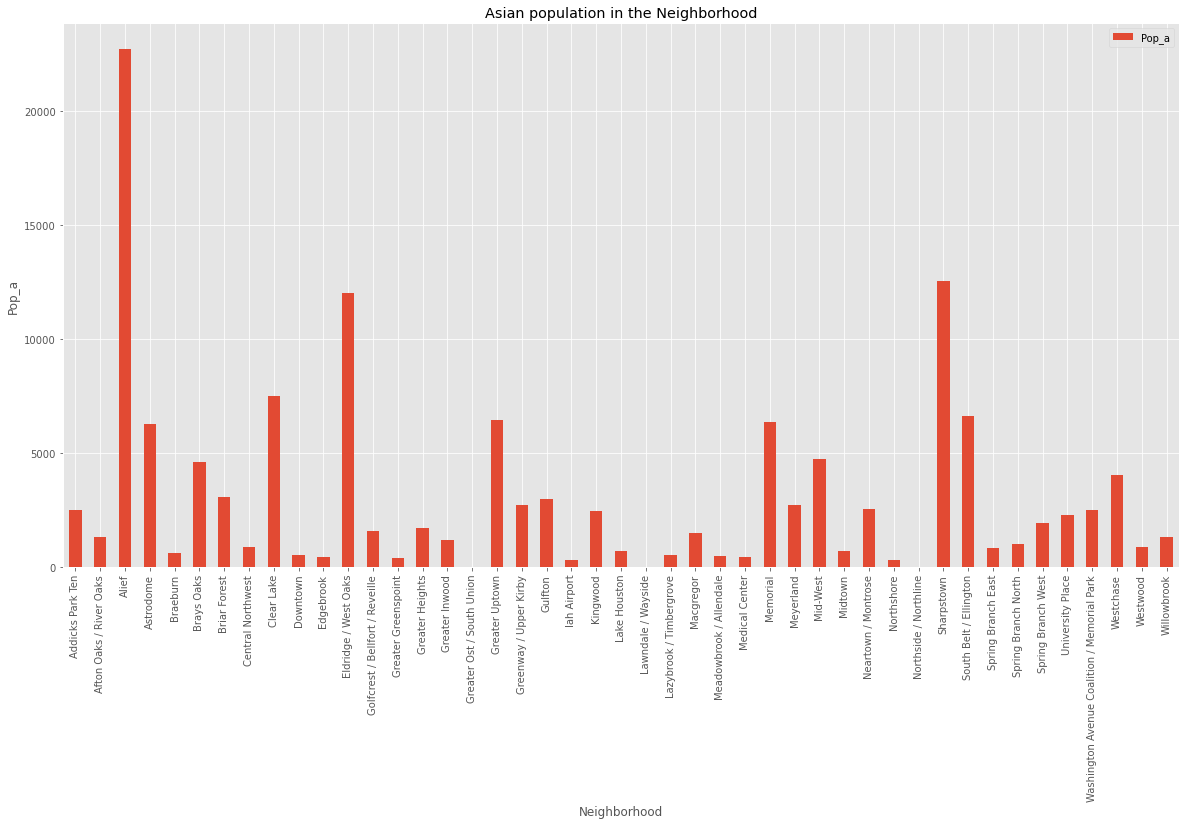

In [69]:
df_hou_select.plot(x = 'Neighborhood',y = 'Pop_a', kind='bar', figsize = (20,10) )

plt.title('Asian population in the Neighborhood')
plt.ylabel('Pop_a')
plt.xlabel('Neighborhood')

plt.show()

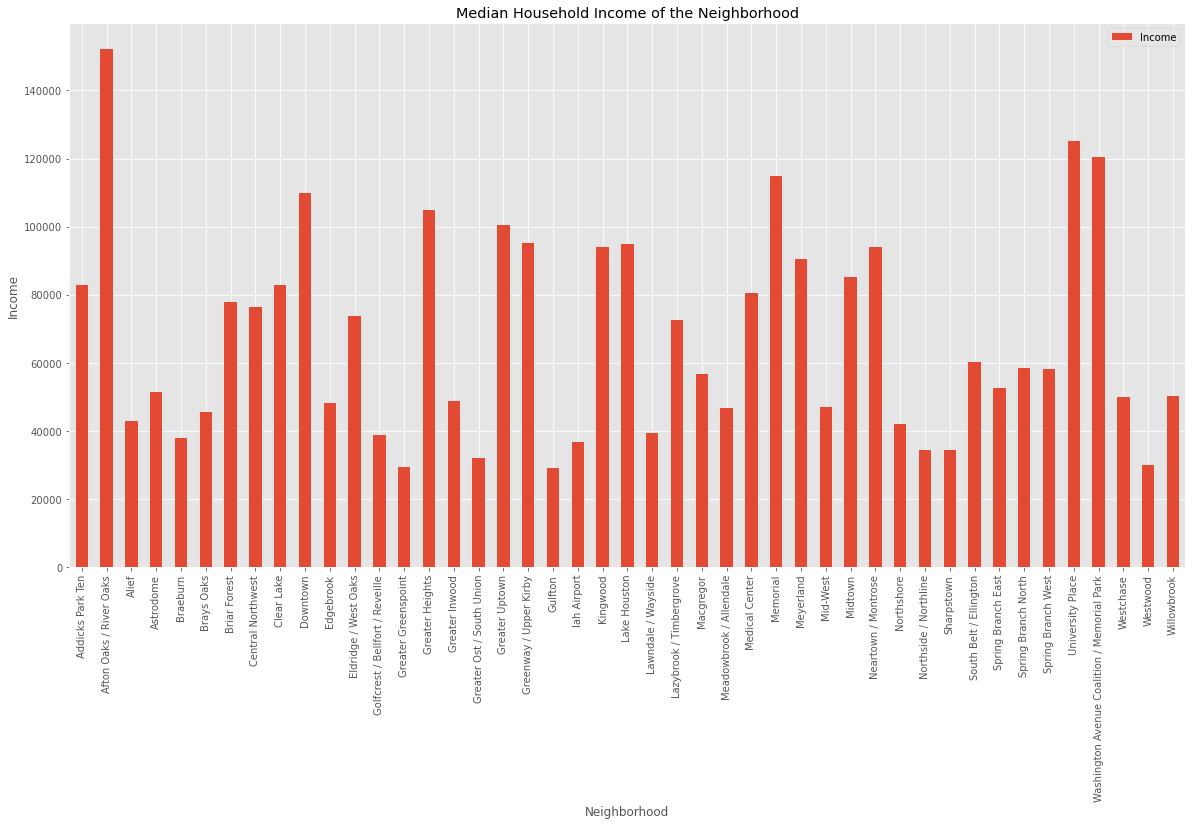

In [70]:
df_hou_select.plot(x = 'Neighborhood',y = 'Income', kind='bar', figsize = (20,10) )

plt.title('Median Household Income of the Neighborhood')
plt.ylabel('Income')
plt.xlabel('Neighborhood')

plt.show()

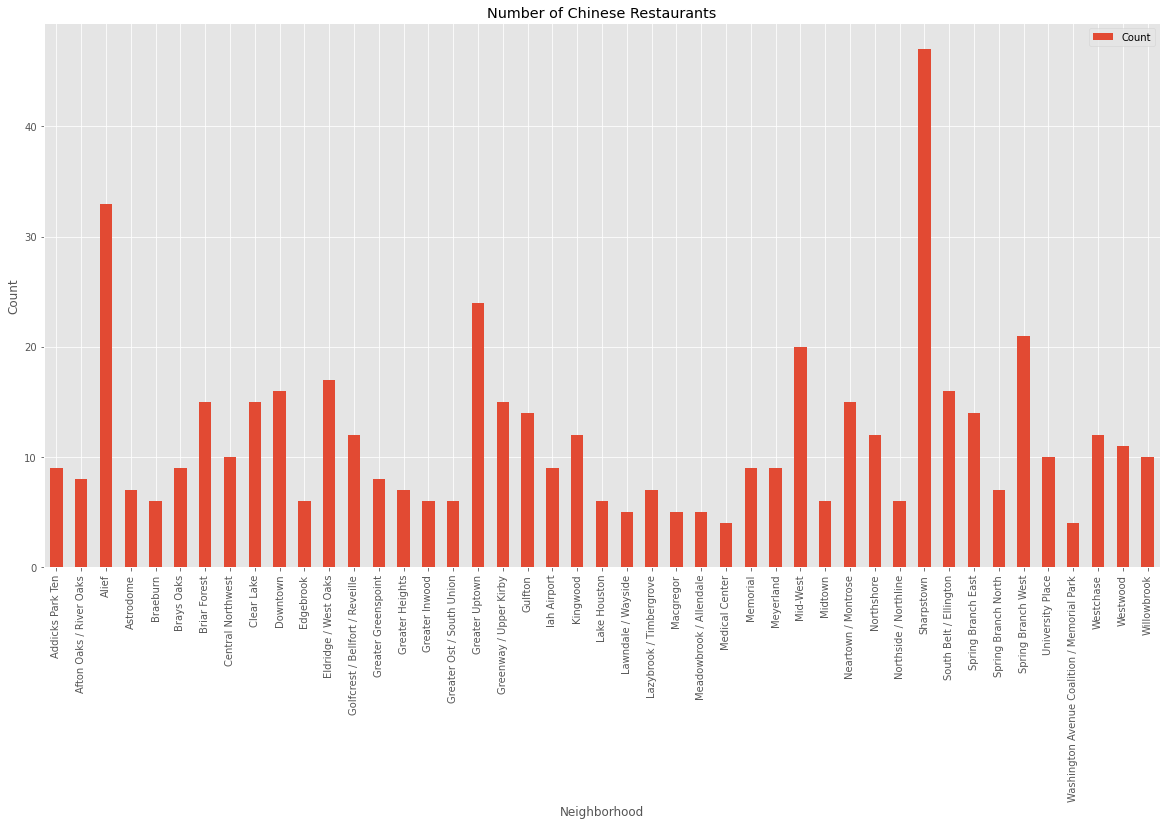

In [71]:
df_hou_select.plot(x = 'Neighborhood',y = 'Count', kind='bar', figsize = (20,10) )

plt.title('Number of Chinese Restaurants')
plt.ylabel('Count')
plt.xlabel('Neighborhood')

plt.show()

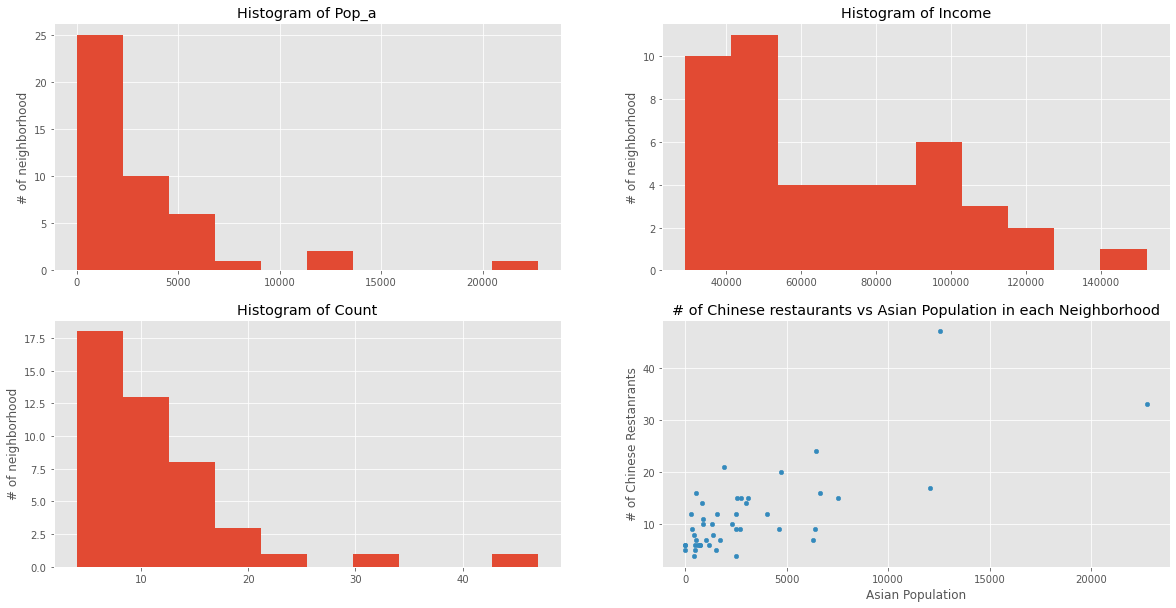

In [76]:
# initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(30, 30))

# colors uses a color map, which will produce an array of colors based on
# the number of labels. We use set(k_means_labels) to get the
# unique labels.
#colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

headers = ['Pop_a','Income', 'Count']

for i, val in enumerate(headers):
    ax = fig.add_subplot(2, 2, i+1)
    df_hou_select[val].plot(kind='hist', figsize=(20, 10), ax=ax)
    ax.set_title('Histogram of {}'.format(val))
#    ax.set_xlabel(val)
    ax.set_ylabel('# of neighborhood')

ax = fig.add_subplot(2,2,4)
df_hou_select.plot(x = 'Pop_a',y = 'Count', kind='scatter', figsize = (20,10), ax=ax )
ax.set_title('# of Chinese restaurants vs Asian Population in each Neighborhood')
ax.set_xlabel('Asian Population')
ax.set_ylabel('# of Chinese Restanrants')
    
plt.show()


### Preprocess the input data: Number of Asian population, Income, and number of Chinese restaurants

In [77]:
X = df_hou_select.drop(['Neighborhood','Latitude','Longitude'], axis=1)
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-0.13753389,  0.51790934, -0.3400102 ],
       [-0.41491114,  2.8280276 , -0.46751403],
       [ 4.76562372, -0.8150065 ,  2.7200816 ],
       [ 0.78229266, -0.52860696, -0.59501785],
       [-0.59223878, -0.98350233, -0.72252168]])

In [78]:
len(X)

45

In [79]:
df_norm = pd.DataFrame(X)
df_norm['Neighborhood'] = df_hou_select['Neighborhood']
fixed_columns = [df_norm.columns[-1]]+list(df_norm.columns[:-1])
df_norm = df_norm[fixed_columns]
df_norm.columns = ['Neighborhood','Pop_a','Income','Count']
df_norm.head()

,Neighborhood,Pop_a,Income,Count
0,Addicks Park Ten,-0.137534,0.517909,-0.340010
1,Afton Oaks / River Oaks,-0.414911,2.828028,-0.467514
2,Alief,4.765624,-0.815006,2.720082
3,Astrodome,0.782293,-0.528607,-0.595018
4,Braeburn,-0.592239,-0.983502,-0.722522


In [80]:
df_norm.describe()

,Pop_a,Income,Count
count,4.500000e+01,4.500000e+01,4.500000e+01
mean,3.207311e-17,-1.282924e-16,9.560254e-17
std,1.011300e+00,1.011300e+00,1.011300e+00
min,-7.390428e-01,-1.275675e+00,-9.775293e-01
25%,-5.922388e-01,-8.150065e-01,-7.225217e-01
50%,-3.579822e-01,-3.018434e-01,-3.400102e-01
75%,3.213862e-03,7.767769e-01,4.250128e-01
max,4.765624e+00,2.828028e+00,4.505135e+00


### Cluster Neighborhoods

In [81]:
df_selectN = df_norm.drop(['Neighborhood'],1)

In [82]:
# choose 6 clusters
kclusters = 6

#run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_selectN)

kmeans.labels_[:]

array([5, 0, 3, 1, 1, 1, 2, 5, 2, 5, 1, 2, 1, 1, 5, 1, 1, 2, 5, 1, 1, 5,
       5, 1, 5, 1, 1, 5, 0, 5, 2, 5, 5, 1, 1, 4, 2, 1, 1, 2, 0, 0, 1, 1,
       1])

Let's create a new dataframe that includes the cluster

In [83]:
df_out = df_hou_select.copy()


df_out.insert(3, 'Clustering', kmeans.labels_)
df_out.head()

,Neighborhood,Latitude,Longitude,Clustering,Pop_a,Income,Count
0,Addicks Park Ten,29.814219,-95.645506,5,2483,82869,9
1,Afton Oaks / River Oaks,29.748383,-95.440128,0,1338,152092,8
2,Alief,29.683789,-95.592861,3,22723,42928,33
3,Astrodome,29.684442,-95.403142,1,6280,51510,7
4,Braeburn,29.676989,-95.528342,1,606,37879,6


Display the clustering on Houston map

In [84]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_out['Latitude'], df_out['Longitude'], df_out['Neighborhood'], df_out['Clustering']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Analysis the clustering result

In [85]:
df_out.head()

,Neighborhood,Latitude,Longitude,Clustering,Pop_a,Income,Count
0,Addicks Park Ten,29.814219,-95.645506,5,2483,82869,9
1,Afton Oaks / River Oaks,29.748383,-95.440128,0,1338,152092,8
2,Alief,29.683789,-95.592861,3,22723,42928,33
3,Astrodome,29.684442,-95.403142,1,6280,51510,7
4,Braeburn,29.676989,-95.528342,1,606,37879,6


In [86]:
bin_labels=['low','lowmid','mid','midhigh','high']
cols = ['Pop_a','Income','Count']

for col in cols:
    bins = np.linspace(min(df_out[col]), max(df_out[col]),6)
    df_out['binned_'+col] = pd.cut(df_out[col],bins,labels=bin_labels, include_lowest = True)
df_out_binned = df_out.drop(['Latitude', 'Longitude','Pop_a','Income','Count'], axis=1)
df_out_binned.head()

,Neighborhood,Clustering,binned_Pop_a,binned_Income,binned_Count
0,Addicks Park Ten,5,low,mid,low
1,Afton Oaks / River Oaks,0,low,high,low
2,Alief,3,high,low,midhigh
3,Astrodome,1,lowmid,low,low
4,Braeburn,1,low,low,low


Exame each group

In [87]:
df_out[df_out['Clustering'] == 0].reset_index().drop(['index','Clustering'], axis=1)

,Neighborhood,Latitude,Longitude,Pop_a,Income,Count,binned_Pop_a,binned_Income,binned_Count
0,Afton Oaks / River Oaks,29.748383,-95.440128,1338,152092,8,low,high,low
1,Memorial,29.772700,-95.576286,6366,114954,9,lowmid,midhigh,low
2,University Place,29.718444,-95.408944,2297,125030,10,low,midhigh,low
3,Washington Avenue Coalition / Memorial Park,29.776478,-95.435006,2517,120572,4,low,midhigh,low


In [88]:
df_out[df_out['Clustering'] == 1].reset_index().drop(['index','Clustering'], axis=1)

,Neighborhood,Latitude,Longitude,Pop_a,Income,Count,binned_Pop_a,binned_Income,binned_Count
0,Astrodome,29.684442,-95.403142,6280,51510,7,lowmid,low,low
1,Braeburn,29.676989,-95.528342,606,37879,6,low,low,low
2,Brays Oaks,29.655069,-95.527817,4590,45474,9,lowmid,low,low
3,Edgebrook,29.645381,-95.226556,463,48311,6,low,low,low
4,Golfcrest / Bellfort / Reveille,29.685214,-95.296325,1573,38883,12,low,low,low
5,Greater Greenspoint,29.940717,-95.413872,402,29305,8,low,low,low
6,Greater Inwood,29.865697,-95.480475,1189,48924,6,low,low,low
7,Greater Ost / South Union,29.691189,-95.352883,0,32118,6,low,low,low
8,Gulfton,29.716636,-95.480700,2989,29124,14,low,low,lowmid
9,Iah Airport,29.990225,-95.336783,305,36844,9,low,low,low


In [89]:
df_out[df_out['Clustering'] == 2].reset_index().drop(['index','Clustering'], axis=1)

,Neighborhood,Latitude,Longitude,Pop_a,Income,Count,binned_Pop_a,binned_Income,binned_Count
0,Briar Forest,29.747739,-95.587269,3064,77819,15,low,lowmid,lowmid
1,Clear Lake,29.585614,-95.132725,7509,82744,15,lowmid,mid,lowmid
2,Eldridge / West Oaks,29.756956,-95.659072,12037,73874,17,mid,lowmid,lowmid
3,Greater Uptown,29.761469,-95.467242,6450,100485,24,lowmid,mid,mid
4,Mid-West,29.737519,-95.514211,4725,47138,20,lowmid,low,lowmid
5,South Belt / Ellington,29.601289,-95.216136,6611,60278,16,lowmid,lowmid,lowmid
6,Spring Branch West,29.790917,-95.544683,1920,58305,21,low,lowmid,lowmid


In [90]:
df_out[df_out['Clustering'] == 3].reset_index().drop(['index','Clustering'], axis=1)

,Neighborhood,Latitude,Longitude,Pop_a,Income,Count,binned_Pop_a,binned_Income,binned_Count
0,Alief,29.683789,-95.592861,22723,42928,33,high,low,midhigh


In [91]:
df_out[df_out['Clustering'] == 4].reset_index().drop(['index','Clustering'], axis=1)

,Neighborhood,Latitude,Longitude,Pop_a,Income,Count,binned_Pop_a,binned_Income,binned_Count
0,Sharpstown,29.705228,-95.521303,12536,34448,47,mid,low,high


In [92]:
df_out[df_out['Clustering'] == 5].reset_index().drop(['index','Clustering'], axis=1)

,Neighborhood,Latitude,Longitude,Pop_a,Income,Count,binned_Pop_a,binned_Income,binned_Count
0,Addicks Park Ten,29.814219,-95.645506,2483,82869,9,low,mid,low
1,Central Northwest,29.832189,-95.444989,869,76430,10,low,lowmid,low
2,Downtown,29.755814,-95.357353,515,109949,16,low,midhigh,lowmid
3,Greater Heights,29.796300,-95.399083,1726,104870,7,low,midhigh,low
4,Greenway / Upper Kirby,29.716047,-95.433261,2719,95093,15,low,mid,lowmid
5,Kingwood,30.050417,-95.184583,2474,94150,12,low,mid,low
6,Lake Houston,29.972294,-95.137950,722,95026,6,low,mid,low
7,Lazybrook / Timbergrove,29.724886,-95.311325,540,72557,7,low,lowmid,low
8,Medical Center,29.701633,-95.393700,449,80388,4,low,mid,low
9,Meyerland,29.686564,-95.464756,2708,90626,9,low,mid,low


# <a id = 'Results'>5. Results </a>
The neighborhood in Houston was clustered into 6 clusters, and we summarized the characteristics for each cluster here.

| Cluster  | 0 | 1| 2 | 3 |4 |5 |
| -------- | ------|------|------|------|------|------|
|Asian population| Low | Low | Mid | High | Mid | Low |
|Income | High | Low | Mid | Low| Low | Mid |
|# of Chinese restaurants | Low | Low | Mid | High | High | Low|

We consider Asian population as the target customer for the new restaurant. Low Asian population (cluster 0, 1 , 5) is not ideal. Cluster 3 and 4 are similar, they have reasonable number of target customers and large number of competitions. It kind of supports our assumption that more Asian population will have more demand for Asian food. But clusters 3 and 4 both have low income, which suggests that the demand is mostly for low-price restaurants. And the competition is high for these neighborhoods. If our stackholder have authentic food, competitive advantage and relative low cost, cluster 3 (only one neighborhood in this cluster, Alief) is still a reasonable choice for opening a Chinese restaurant.  
Cluster 2 has reasonable number of target customers, spending power, which is promising. Mid level of existing Chinese restaurants suggests that there is demand and the competition is not too severe. We would recommend cluster 2 to our stakeholder, 2 neighborhoods to be more specific: Clear Lake and Eldridge/West Oaks.

# <a id = 'Conclusion'>6. Conclusion </a>
In this study, I labeld the neighborhoods in Houston into 6 groups using the following criteria: spending power, target population and number of competitors. Best on this clustering, I recommended cluster 2 to the stakeholder, which has reasonable target population and spending power, and the competition is not severe. To be more specific, 2 neighborhoods from this cluster were recommended: Clear Lake and Eldridge/West Oaks. 

# <a id = 'Discussion'>7. Discussion </a>
The assumption we used in this study may be overly simplified. Here are some limitations of this study: 
1. Asian population may not always prefer Chinese food. And some may crave for a specific branch of Chinese food, for example: Szechuan or Hunan restaurant, not other branches. Further study is needed.
2. Use Median household Income as indicator for spending power does not consider other living costs, such as house price etc. And this study does not consider people going to nearby neighborhood for food.
3. Other factors, such as rent, safety, are not considered in this study.

To further improve this study, we can study the demand for the specify branch of Chinese food if we get more detailed information from our stakeholder. Can and rent cost to the study if the data is available. Use more recent data and more data point from past few years, to understand if there is a growing demand or shrinking demand. Moreover, this study improves the chances of success for our stakeholder, but the food quality and services are still the key to attract and maintain loyal customers.


### Thank you for looking at this study. It is the final project for Coursera class: Applied Data Science Capstone. Any suggest and question is welcomed.